### 1.a Import Libraries

In [1]:
import re
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
import contractions

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cgunn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cgunn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 1.b Load dataset

In [2]:
airline_data = pd.read_csv('Tweets.csv')

#### 1.c Print shape of data

In [3]:
airline_data.shape

(14640, 15)

#### 1.d Description of data

In [4]:
airline_data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
airline_data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [6]:
i = -1
for col in airline_data.columns:
    i = i + 1
    if airline_data[col].dtype == 'object':
        print('Value count for \033[1m', airline_data.columns[i], '\033[0m is \n',airline_data[col].value_counts(), '\n')

Value count for  airline_sentiment  is 
 negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64 

Value count for  negativereason  is 
 Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64 

Value count for  airline  is 
 United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64 

Value count for  airline_sentiment_gold  is 
 negative    32
positive     5
neutral      3
Name: airline_sentiment_gold, dtype: int64 

Value count for  name  is 
 JetBlueNews        63
kbosspotter        32
_mhertz            29
otis

In [7]:
airline_data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [9]:
airline_data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
airline_data1 = airline_data.drop('tweet_id', axis = 1)

In [11]:
airline_data1

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [12]:
airline_data1.describe()

,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.000000,10522.000000,14640.000000
mean,0.900169,0.638298,0.082650
std,0.162830,0.330440,0.745778
min,0.335000,0.000000,0.000000
25%,0.692300,0.360600,0.000000
50%,1.000000,0.670600,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,44.000000


In [13]:
airline_data1.head(5)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### 2 Understanding data-columns 

#### 2.a Dropping all columns except 'text' and 'airline_sentiment'

In [14]:
airlinedata = airline_data1[['text','airline_sentiment']]

#### 2.b shape of data

In [15]:
airlinedata.shape

(14640, 2)

#### 2.c print first 5 rows

In [16]:
airlinedata.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### 3  Text pre-processing

#### 3.a html Tag removal

In [17]:
airlinedata.reset_index(inplace = True)

In [18]:
print(airlinedata)

       index                                               text  \
0          0                @VirginAmerica What @dhepburn said.   
1          1  @VirginAmerica plus you've added commercials t...   
2          2  @VirginAmerica I didn't today... Must mean I n...   
3          3  @VirginAmerica it's really aggressive to blast...   
4          4  @VirginAmerica and it's a really big bad thing...   
...      ...                                                ...   
14635  14635  @AmericanAir thank you we got on a different f...   
14636  14636  @AmericanAir leaving over 20 minutes Late Flig...   
14637  14637  @AmericanAir Please bring American Airlines to...   
14638  14638  @AmericanAir you have my money, you change my ...   
14639  14639  @AmericanAir we have 8 ppl so we need 2 know h...   

      airline_sentiment  
0               neutral  
1              positive  
2               neutral  
3              negative  
4              negative  
...                 ...  
14635        

In [19]:
airlinedata[['index', 'text']]

,index,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...
3,3,@VirginAmerica it's really aggressive to blast...
4,4,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,14635,@AmericanAir thank you we got on a different f...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...
14637,14637,@AmericanAir Please bring American Airlines to...
14638,14638,"@AmericanAir you have my money, you change my ..."


In [20]:
def remove_html_tag(text):
    text1 = BeautifulSoup(text, 'html.parser')
    return text1.get_text()

airlinedata['non_html_text'] = ''

for i, row in airlinedata.iterrows():
    text_val = airlinedata['text'].iloc[i]
    text2 = remove_html_tag(text_val)
#     print(i)
#     print(text2)

    airlinedata['non_html_text'].iat[i] = text2

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,index,text,airline_sentiment,non_html_text
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ..."


In [21]:
#airlinedata.to_csv('airlinedata_non_html1.csv')

#### 3.a.1  remove http://t.co/ , https://t.co/ , html, and www.

In [22]:
def remove_http_www(text):
    text3 = text.replace("http://t.co/", "")
    return text3

def remove_https_www(text):
    text4 = text.replace("https://t.co/", "")
    return text4

def remove_html_www(text):
    text4A = text.replace("html", "")
    return text4A

def remove_www(text):
    text4B = text.replace("www", "")
    return text4B

airlinedata['non_http_www_text'] = ''

for i, row in airlinedata.iterrows():
    text_val1 = airlinedata['non_html_text'].iloc[i]  # use the html tag removed text and then remove http/https/www
    text5 = remove_http_www(text_val1)
    text6 = remove_https_www(text5)
    text6A = remove_html_www(text6)
    text6B = remove_www(text6A)
#     print(i)
#     print(text2)

    airlinedata['non_http_www_text'].iat[i] = text6A

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,text,airline_sentiment,non_html_text,non_http_www_text
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ..."


In [23]:
#airlinedata.to_csv('airlinedata_non_html1.csv')

#### 3 Cleanup and Tokenization/Lemmatization

#### Replacing contractions before Tokenization

In [24]:
def replace_contractions(text):
    return contractions.fix(text)

airlinedata['non_contractions_text'] = ''

for i, row in airlinedata.iterrows():
    text_val2 = airlinedata['non_http_www_text'].iloc[i]  # use the http/www tag removed text and then remove contractions
    text7 = replace_contractions(text_val2)

    airlinedata['non_contractions_text'].iat[i] = text7

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,index,text,airline_sentiment,non_html_text,non_http_www_text,non_contractions_text
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...
...,...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ..."


In [25]:
airlinedata.to_csv('airlinedata_non_contractions.csv')

#### Remove accented characters

In [26]:
#remove accented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

airlinedata['non_accented_text'] = ''

for i, row in airlinedata.iterrows():
    text_val3 = airlinedata['non_contractions_text'].iloc[i]  # use the contractions removed text and then remove accented
    text8 = remove_accented_chars(text_val3)

    airlinedata['non_accented_text'].iat[i] = text8

airlinedata


C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,index,text,airline_sentiment,non_html_text,non_http_www_text,non_contractions_text,non_accented_text
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...,@VirginAmerica plus you have added commercials...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...,@VirginAmerica I did not today... Must mean I ...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...,@VirginAmerica it is really aggressive to blas...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...,@VirginAmerica and it is a really big bad thin...
...,...,...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ..."


In [27]:
airlinedata.to_csv('airlinedata_non_accented.csv')

#### 3.d Remove special characters and punctuations

In [28]:
#remove special characters
def remove_special_chars(text):
    pattern = re.compile(r'[^a-zA-Z0-9 ]') # match only lower and upper case alpha plus numbers
    matches = pattern.sub('',text)
    return matches

airlinedata['special_char_removed'] = ''

for i, row in airlinedata.iterrows():
    text_val4 = airlinedata['non_accented_text'].iloc[i]  # use the accent removed text and then remove special char's
    text9 = remove_special_chars(text_val4)

    airlinedata['special_char_removed'].iat[i] = text9

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,index,text,airline_sentiment,non_html_text,non_http_www_text,non_contractions_text,non_accented_text,special_char_removed
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...,@VirginAmerica plus you have added commercials...,VirginAmerica plus you have added commercials ...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...,@VirginAmerica I did not today... Must mean I ...,VirginAmerica I did not today Must mean I need...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...,@VirginAmerica it is really aggressive to blas...,VirginAmerica it is really aggressive to blast...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...,@VirginAmerica and it is a really big bad thin...,VirginAmerica and it is a really big bad thing...
...,...,...,...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,AmericanAir thank you we got on a different fl...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,AmericanAir leaving over 20 minutes Late Fligh...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,AmericanAir Please bring American Airlines to ...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...",AmericanAir you have my money you change my fl...


In [29]:
airlinedata.to_csv('airlinedata_no_special_char.csv')

#### 3.c Remove numbers

In [30]:
#remove numbers
def remove_numbers(text):
    pattern = re.compile(r'[^a-zA-Z ]')  # match only lower and upper case alpha
    matches = pattern.sub('',text)
    return matches

airlinedata['numbers_removed'] = ''

for i, row in airlinedata.iterrows():
    text_val5 = airlinedata['special_char_removed'].iloc[i]  # use the special char removed text and then remove numbers
    text10 = remove_numbers(text_val5)

    airlinedata['numbers_removed'].iat[i] = text10

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,index,text,airline_sentiment,non_html_text,non_http_www_text,non_contractions_text,non_accented_text,special_char_removed,numbers_removed
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said,VirginAmerica What dhepburn said
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...,@VirginAmerica plus you have added commercials...,VirginAmerica plus you have added commercials ...,VirginAmerica plus you have added commercials ...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...,@VirginAmerica I did not today... Must mean I ...,VirginAmerica I did not today Must mean I need...,VirginAmerica I did not today Must mean I need...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...,@VirginAmerica it is really aggressive to blas...,VirginAmerica it is really aggressive to blast...,VirginAmerica it is really aggressive to blast...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...,@VirginAmerica and it is a really big bad thin...,VirginAmerica and it is a really big bad thing...,VirginAmerica and it is a really big bad thing...
...,...,...,...,...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,AmericanAir thank you we got on a different fl...,AmericanAir thank you we got on a different fl...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,AmericanAir leaving over 20 minutes Late Fligh...,AmericanAir leaving over minutes Late Flight ...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,AmericanAir Please bring American Airlines to ...,AmericanAir Please bring American Airlines to ...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...",AmericanAir you have my money you change my fl...,AmericanAir you have my money you change my fl...


In [31]:
airlinedata.to_csv('airlinedata_numbers_removed.csv')

#### 3.e conversion to lower case

In [32]:
# convert to lower case
def lower_case(text):
    new_word = text.lower()  
    return new_word

airlinedata['lower_case'] = ''

for i, row in airlinedata.iterrows():
    text_val6 = airlinedata['numbers_removed'].iloc[i]  # use the special char removed text and then remove numbers
    text11 = lower_case(text_val6)

    airlinedata['lower_case'].iat[i] = text11

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,text,airline_sentiment,non_html_text,non_http_www_text,non_contractions_text,non_accented_text,special_char_removed,numbers_removed,lower_case
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said,VirginAmerica What dhepburn said,virginamerica what dhepburn said
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...,@VirginAmerica plus you have added commercials...,VirginAmerica plus you have added commercials ...,VirginAmerica plus you have added commercials ...,virginamerica plus you have added commercials ...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...,@VirginAmerica I did not today... Must mean I ...,VirginAmerica I did not today Must mean I need...,VirginAmerica I did not today Must mean I need...,virginamerica i did not today must mean i need...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...,@VirginAmerica it is really aggressive to blas...,VirginAmerica it is really aggressive to blast...,VirginAmerica it is really aggressive to blast...,virginamerica it is really aggressive to blast...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...,@VirginAmerica and it is a really big bad thin...,VirginAmerica and it is a really big bad thing...,VirginAmerica and it is a really big bad thing...,virginamerica and it is a really big bad thing...
...,...,...,...,...,...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,AmericanAir thank you we got on a different fl...,AmericanAir thank you we got on a different fl...,americanair thank you we got on a different fl...
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,AmericanAir leaving over 20 minutes Late Fligh...,AmericanAir leaving over minutes Late Flight ...,americanair leaving over minutes late flight ...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,AmericanAir Please bring American Airlines to ...,AmericanAir Please bring American Airlines to ...,americanair please bring american airlines to ...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...",AmericanAir you have my money you change my fl...,AmericanAir you have my money you change my fl...,americanair you have my money you change my fl...


#### Removing stop words , excepting no/not , since it is best practice before building model

In [33]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# remove stop words
def stop_word_remove(text):
    split_words = text.split()  # to have the words split else charcter wise stopword gets checked
    new_word1 = [w for w in split_words if not w in stopword_list ]  
    return (" ".join(new_word1))

airlinedata['stop_word_removed'] = ''

for i, row in airlinedata.iterrows():
    text_val7 = airlinedata['lower_case'].iloc[i]  # use the lower case text and then remove stop words    text12 = stop_word_remove(text_val7)
    text12 = stop_word_remove(text_val7)
    
    airlinedata['stop_word_removed'].iat[i] = text12

airlinedata

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,index,text,airline_sentiment,non_html_text,non_http_www_text,non_contractions_text,non_accented_text,special_char_removed,numbers_removed,lower_case,stop_word_removed
0,0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said,VirginAmerica What dhepburn said,virginamerica what dhepburn said,virginamerica dhepburn said
1,1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...,@VirginAmerica plus you have added commercials...,VirginAmerica plus you have added commercials ...,VirginAmerica plus you have added commercials ...,virginamerica plus you have added commercials ...,virginamerica plus added commercials experienc...
2,2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...,@VirginAmerica I did not today... Must mean I ...,VirginAmerica I did not today Must mean I need...,VirginAmerica I did not today Must mean I need...,virginamerica i did not today must mean i need...,virginamerica not today must mean need take an...
3,3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...,@VirginAmerica it is really aggressive to blas...,VirginAmerica it is really aggressive to blast...,VirginAmerica it is really aggressive to blast...,virginamerica it is really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...,@VirginAmerica and it is a really big bad thin...,VirginAmerica and it is a really big bad thing...,VirginAmerica and it is a really big bad thing...,virginamerica and it is a really big bad thing...,virginamerica really big bad thing
...,...,...,...,...,...,...,...,...,...,...,...
14635,14635,@AmericanAir thank you we got on a different f...,positive,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,@AmericanAir thank you we got on a different f...,AmericanAir thank you we got on a different fl...,AmericanAir thank you we got on a different fl...,americanair thank you we got on a different fl...,americanair thank got different flight chicago
14636,14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,@AmericanAir leaving over 20 minutes Late Flig...,AmericanAir leaving over 20 minutes Late Fligh...,AmericanAir leaving over minutes Late Flight ...,americanair leaving over minutes late flight ...,americanair leaving minutes late flight no war...
14637,14637,@AmericanAir Please bring American Airlines to...,neutral,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,@AmericanAir Please bring American Airlines to...,AmericanAir Please bring American Airlines to ...,AmericanAir Please bring American Airlines to ...,americanair please bring american airlines to ...,americanair please bring american airlines bla...
14638,14638,"@AmericanAir you have my money, you change my ...",negative,"@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change my ...","@AmericanAir you have my money, you change m

In [34]:
airlinedata.to_csv('airlinedata_stopwords.csv')

#### Drop unnecessary columns from the dataframe

In [35]:
# airlinedata_cleaned_text = airlinedata[['airline_sentiment', 'stop_word_removed']]
# airlinedata_cleaned = airlinedata_cleaned_text.to_frame()
# airlinedata_cleaned

In [36]:
airlinedata_cleaned = airlinedata[['airline_sentiment', 'stop_word_removed']]

In [37]:
airlinedata_cleaned

,airline_sentiment,stop_word_removed
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercials experienc...
2,neutral,virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing
...,...,...
14635,positive,americanair thank got different flight chicago
14636,negative,americanair leaving minutes late flight no war...
14637,neutral,americanair please bring american airlines bla...
14638,negative,americanair money change flight not answer pho...


#### 3.b Tokenization

In [38]:
# Tokenization

treebanktokenizer = TreebankWordTokenizer()

def tokenize(text):
    treetokens = treebanktokenizer.tokenize(text) 
     
    return (treetokens)

airlinedata_cleaned['tokenized'] = ''

for i, row in airlinedata_cleaned.iterrows():
    text_val8 = airlinedata_cleaned['stop_word_removed'].iloc[i] 
    text13 = tokenize(text_val8)
    
    airlinedata_cleaned['tokenized'].iat[i] = text13

airlinedata_cleaned

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,airline_sentiment,stop_word_removed,tokenized
0,neutral,virginamerica dhepburn said,"[virginamerica, dhepburn, said]"
1,positive,virginamerica plus added commercials experienc...,"[virginamerica, plus, added, commercials, expe..."
2,neutral,virginamerica not today must mean need take an...,"[virginamerica, not, today, must, mean, need, ..."
3,negative,virginamerica really aggressive blast obnoxiou...,"[virginamerica, really, aggressive, blast, obn..."
4,negative,virginamerica really big bad thing,"[virginamerica, really, big, bad, thing]"
...,...,...,...
14635,positive,americanair thank got different flight chicago,"[americanair, thank, got, different, flight, c..."
14636,negative,americanair leaving minutes late flight no war...,"[americanair, leaving, minutes, late, flight, ..."
14637,neutral,americanair please bring american airlines bla...,"[americanair, please, bring, american, airline..."
14638,negative,americanair money change flight not answer pho...,"[americanair, money, change, flight, not, answ..."


In [39]:
airlinedata_cleaned.to_csv('airlinedata_tokenized.csv')

#### 3.g  Joining words in list in column 'tokenized' to text string

In [40]:
def convert_to_string(text):
    return(" ".join(text))

airlinedata_cleaned['token_to_string'] = ''

for i, row in airlinedata_cleaned.iterrows():
    text_val9 = airlinedata_cleaned['tokenized'].iloc[i] 
    text14 = convert_to_string(text_val9)
    
    airlinedata_cleaned['token_to_string'].iat[i] = text14

airlinedata_cleaned

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,airline_sentiment,stop_word_removed,tokenized,token_to_string
0,neutral,virginamerica dhepburn said,"[virginamerica, dhepburn, said]",virginamerica dhepburn said
1,positive,virginamerica plus added commercials experienc...,"[virginamerica, plus, added, commercials, expe...",virginamerica plus added commercials experienc...
2,neutral,virginamerica not today must mean need take an...,"[virginamerica, not, today, must, mean, need, ...",virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...,"[virginamerica, really, aggressive, blast, obn...",virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing,"[virginamerica, really, big, bad, thing]",virginamerica really big bad thing
...,...,...,...,...
14635,positive,americanair thank got different flight chicago,"[americanair, thank, got, different, flight, c...",americanair thank got different flight chicago
14636,negative,americanair leaving minutes late flight no war...,"[americanair, leaving, minutes, late, flight, ...",americanair leaving minutes late flight no war...
14637,neutral,americanair please bring american airlines bla...,"[americanair, please, bring, american, airline...",americanair please bring american airlines bla...
14638,negative,americanair money change flight not answer pho...,"[americanair, money, change, flight, not, answ...",americanair money change flight not answer pho...


In [41]:
airlinedata_cleaned.to_csv('airlinedata_token_to_string.csv')

#### Lemmatizing

In [42]:
text_lemmatize = spacy.load(r'C:\Users\cgunn\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1', parse=True, tag=True, entity=True)

def lemmatize_text(text):
    text = text_lemmatize(text)
    text = " ".join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return (text)

airlinedata_cleaned['lemmatized'] = ''

for i, row in airlinedata_cleaned.iterrows():
    text_val10 = airlinedata_cleaned['token_to_string'].iloc[i] 
    text17 = lemmatize_text(text_val10)
    
    airlinedata_cleaned['lemmatized'].iat[i] = text17

airlinedata_cleaned

C:\Users\cgunn\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,stop_word_removed,tokenized,token_to_string,lemmatized
0,neutral,virginamerica dhepburn said,"[virginamerica, dhepburn, said]",virginamerica dhepburn said,virginamerica dhepburn say
1,positive,virginamerica plus added commercials experienc...,"[virginamerica, plus, added, commercials, expe...",virginamerica plus added commercials experienc...,virginamerica plus add commercial experience t...
2,neutral,virginamerica not today must mean need take an...,"[virginamerica, not, today, must, mean, need, ...",virginamerica not today must mean need take an...,virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...,"[virginamerica, really, aggressive, blast, obn...",virginamerica really aggressive blast obnoxiou...,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing,"[virginamerica, really, big, bad, thing]",virginamerica really big bad thing,virginamerica really big bad thing
...,...,...,...,...,...
14635,positive,americanair thank got different flight chicago,"[americanair, thank, got, different, flight, c...",americanair thank got different flight chicago,americanair thank get different flight chicago
14636,negative,americanair leaving minutes late flight no war...,"[americanair, leaving, minutes, late, flight, ...",americanair leaving minutes late flight no war...,americanair leaving minute late flight no warn...
14637,neutral,americanair please bring american airlines bla...,"[americanair, please, bring, american, airline...",americanair please bring american airlines bla...,americanair please bring american airlines bla...
14638,negative,americanair money change flight not answer pho...,"[americanair, money, change, flight, not, answ...",americanair money change flight not answer pho...,americanair money change flight not answer pho...


In [43]:
airlinedata_cleaned.to_csv('airlinedata_lemmatized.csv')

In [44]:
airlinedata_final = airlinedata_cleaned[['airline_sentiment', 'lemmatized']]

#### 3.h  Print 5 rows od pre-processed data

In [45]:
airlinedata_final.head(5)

,airline_sentiment,lemmatized
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercial experience t...
2,neutral,virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


### Vectorization

#### 4.a CountVectorizer

In [46]:
vectorizer = CountVectorizer()
# tokenize and build vocab

airlinedata_countvector = vectorizer.fit_transform(airlinedata_final['lemmatized'])

airlinedata_countvector_array = airlinedata_countvector.toarray()
# summarize
#print(vectorizer.vocabulary_)

print('\n', 'CountVector data shape is : ',airlinedata_countvector.shape)
print('CountVector data type is : ', type(airlinedata_countvector), '\n')
print('\n', 'CountVector data print : \n', airlinedata_countvector)
print('\n', 'CountVector data array is : \n', airlinedata_countvector_array)


 CountVector data shape is :  (14640, 12975)
CountVector data type is :  <class 'scipy.sparse.csr.csr_matrix'> 


 CountVector data print : 
   (0, 12139)	1
  (0, 2909)	1
  (0, 9821)	1
  (1, 12139)	1
  (1, 8646)	1
  (1, 130)	1
  (1, 2113)	1
  (1, 3743)	1
  (1, 10932)	1
  (2, 12139)	1
  (2, 7764)	1
  (2, 11347)	1
  (2, 7395)	1
  (2, 6958)	1
  (2, 7511)	1
  (2, 10942)	1
  (2, 512)	1
  (2, 11521)	1
  (3, 12139)	1
  (3, 9193)	1
  (3, 212)	1
  (3, 1182)	1
  (3, 7904)	1
  (3, 3527)	1
  (3, 4807)	1
  :	:
  (14637, 407)	1
  (14637, 1169)	1
  (14638, 7764)	1
  (14638, 4056)	1
  (14638, 6785)	1
  (14638, 516)	1
  (14638, 8501)	1
  (14638, 1775)	1
  (14638, 7264)	1
  (14638, 408)	1
  (14638, 10762)	1
  (14638, 2116)	1
  (14639, 4056)	2
  (14639, 9914)	1
  (14639, 6169)	1
  (14639, 7589)	2
  (14639, 8647)	1
  (14639, 7510)	1
  (14639, 11958)	1
  (14639, 8418)	1
  (14639, 6829)	1
  (14639, 8999)	1
  (14639, 10563)	1
  (14639, 408)	1
  (14639, 8741)	1

 CountVector data array is : 
 [[0 0 0 ... 0 0

#### 4.a.i  Get the feature names 

In [47]:
airlinedata_countvector_features = vectorizer.get_feature_names()
airlinedata_countvector_features

['aa',
 'aaaand',
 'aaadvantage',
 'aaalwayslate',
 'aaba',
 'aacom',
 'aacustomerservice',
 'aadavantage',
 'aadelay',
 'aadfw',
 'aadv',
 'aadvantage',
 'aafail',
 'aal',
 'aano',
 'aaron',
 'aarp',
 'aas',
 'aaso',
 'aateam',
 'aau',
 'aaumkazy',
 'aavvoreph',
 'aayavgb',
 'ab',
 'aback',
 'abandon',
 'abandonment',
 'abassinet',
 'abbreve',
 'abc',
 'abcdef',
 'abcletjetbluestreamfeed',
 'abcnetwork',
 'abcnews',
 'abcnewsbayarea',
 'abcs',
 'abcwtvd',
 'abducted',
 'abi',
 'abidfw',
 'abigailedge',
 'ability',
 'able',
 'aboard',
 'aboout',
 'abound',
 'abq',
 'abroad',
 'absolute',
 'absolutely',
 'absorb',
 'absorber',
 'absoulutely',
 'absurd',
 'absurdity',
 'absurdly',
 'abt',
 'abundance',
 'abuse',
 'abused',
 'abysmal',
 'ac',
 'acarlhotmailcom',
 'acc',
 'acce',
 'accelerate',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessibility',
 'accessible',
 'accident',
 'accidentally',
 'accomidate',
 'accommodate',
 'accommodation',
 'accompaniment',
 'accompany',
 'ac

#### 4.a.ii Get the top words occuring in the tweets , after applyting count vectorizer

In [48]:
airlinedata_countvector1 = vectorizer.fit(airlinedata_final['lemmatized'])

sum_words = airlinedata_countvector.sum(axis=0)
print('\n', sum_words)


 [[278   1   1 ...   1   1   1]]


In [49]:
words_freq = [(word, sum_words[0, idx]) for word, idx in airlinedata_countvector1.vocabulary_.items()]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq

[('flight', 4643),
 ('united', 4107),
 ('not', 3884),
 ('americanair', 2957),
 ('southwestair', 2455),
 ('usairway', 2431),
 ('jetblue', 2362),
 ('get', 2107),
 ('thank', 1534),
 ('no', 1470),
 ('hour', 1139),
 ('cancel', 1055),
 ('service', 985),
 ('delay', 955),
 ('help', 936),
 ('customer', 929),
 ('time', 925),
 ('go', 767),
 ('call', 759),
 ('us', 744),
 ('would', 736),
 ('bag', 735),
 ('fly', 733),
 ('plane', 719),
 ('hold', 708),
 ('wait', 703),
 ('make', 676),
 ('usairways', 621),
 ('need', 620),
 ('one', 574),
 ('still', 571),
 ('try', 562),
 ('please', 560),
 ('day', 547),
 ('gate', 534),
 ('back', 526),
 ('virginamerica', 520),
 ('take', 504),
 ('say', 501),
 ('seat', 489),
 ('tell', 485),
 ('airline', 480),
 ('change', 459),
 ('phone', 451),
 ('good', 450),
 ('bad', 448),
 ('know', 436),
 ('like', 431),
 ('late', 425),
 ('today', 419),
 ('check', 414),
 ('guy', 404),
 ('agent', 400),
 ('work', 391),
 ('miss', 385),
 ('ticket', 384),
 ('give', 370),
 ('airport', 364),
 ('way

#### 4.b Tf-IDF vectorizer

In [50]:
vectorizer_tfidf = TfidfVectorizer()
# tokenize and build vocab

airlinedata_tfidfvector = vectorizer_tfidf.fit_transform(airlinedata_final['lemmatized'])

airlinedata_tfidfvector_array = airlinedata_tfidfvector.toarray()

# summarize
# print(vectorizer_tfidf.vocabulary_)

print('\n', 'Tfidf Vector data shape is : \n', airlinedata_tfidfvector.shape)
print('Tfidf Vector data type is : \n', type(airlinedata_tfidfvector))
print('\n', 'Tfidf Vector data print : \n', airlinedata_tfidfvector)
print('\n', 'Tfidf Vector data array : \n', airlinedata_tfidfvector_array)


 Tfidf Vector data shape is : 
 (14640, 12975)
Tfidf Vector data type is : 
 <class 'scipy.sparse.csr.csr_matrix'>

 Tfidf Vector data print : 
   (0, 9821)	0.37932623683331773
  (0, 2909)	0.8470948216652909
  (0, 12139)	0.37221226357781756
  (1, 10932)	0.5933597865765707
  (1, 3743)	0.30840670341891147
  (1, 2113)	0.4616475664375396
  (1, 130)	0.3464448663969138
  (1, 8646)	0.38947563978039546
  (1, 12139)	0.26072144892060495
  (2, 11521)	0.3514606376132151
  (2, 512)	0.33807260025621216
  (2, 10942)	0.2965062912534905
  (2, 7511)	0.2829249254140023
  (2, 6958)	0.40308009156320385
  (2, 7395)	0.4715855679011504
  (2, 11347)	0.30926223649312706
  (2, 7764)	0.1654599267459592
  (2, 12139)	0.2938251463784823
  (3, 9246)	0.3601381842763105
  (3, 6511)	0.2607810746512783
  (3, 3791)	0.3069642183861622
  (3, 4807)	0.34354427202506893
  (3, 3527)	0.30012742585659996
  (3, 7904)	0.3885056646375031
  (3, 1182)	0.3675998076181186
  :	:
  (14637, 1372)	0.40681896856351746
  (14637, 8615)	0.2761

#### 4.b.i  Get the feature names 

In [51]:
airlinedata_tfidfvector_features = vectorizer_tfidf.get_feature_names()
airlinedata_tfidfvector_features

['aa',
 'aaaand',
 'aaadvantage',
 'aaalwayslate',
 'aaba',
 'aacom',
 'aacustomerservice',
 'aadavantage',
 'aadelay',
 'aadfw',
 'aadv',
 'aadvantage',
 'aafail',
 'aal',
 'aano',
 'aaron',
 'aarp',
 'aas',
 'aaso',
 'aateam',
 'aau',
 'aaumkazy',
 'aavvoreph',
 'aayavgb',
 'ab',
 'aback',
 'abandon',
 'abandonment',
 'abassinet',
 'abbreve',
 'abc',
 'abcdef',
 'abcletjetbluestreamfeed',
 'abcnetwork',
 'abcnews',
 'abcnewsbayarea',
 'abcs',
 'abcwtvd',
 'abducted',
 'abi',
 'abidfw',
 'abigailedge',
 'ability',
 'able',
 'aboard',
 'aboout',
 'abound',
 'abq',
 'abroad',
 'absolute',
 'absolutely',
 'absorb',
 'absorber',
 'absoulutely',
 'absurd',
 'absurdity',
 'absurdly',
 'abt',
 'abundance',
 'abuse',
 'abused',
 'abysmal',
 'ac',
 'acarlhotmailcom',
 'acc',
 'acce',
 'accelerate',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessibility',
 'accessible',
 'accident',
 'accidentally',
 'accomidate',
 'accommodate',
 'accommodation',
 'accompaniment',
 'accompany',
 'ac

#### 4.a.ii Get the top words occuring in the tweets , after applyting count vectorizer

In [52]:
airlinedata_tfidfvector1 = vectorizer_tfidf.fit(airlinedata_final['lemmatized'])

sum_words1 = airlinedata_tfidfvector.sum(axis=0)
print('\n', sum_words1)


 [[68.44397017  0.38464889  0.41975611 ...  0.50254611  0.49900825
   0.41612755]]


In [53]:
words_freq1 = [(word1, sum_words1[0, idx]) for word1, idx in airlinedata_tfidfvector1.vocabulary_.items()]

words_freq1 =sorted(words_freq1, key = lambda x: x[1], reverse=True)
words_freq1

[('flight', 599.1023082532387),
 ('united', 570.8411151750346),
 ('not', 509.6215539407774),
 ('americanair', 474.01587974361246),
 ('jetblue', 432.1902661101106),
 ('southwestair', 426.60270782079607),
 ('usairway', 420.17800544560856),
 ('thank', 414.2983262957665),
 ('get', 351.69341915660226),
 ('no', 263.8355827794621),
 ('hour', 234.36984108367344),
 ('cancel', 211.34371997013625),
 ('help', 201.98680328764834),
 ('delay', 200.571500691713),
 ('service', 200.38793700382328),
 ('customer', 191.5857562675942),
 ('time', 188.69894077149306),
 ('call', 169.80608489435605),
 ('hold', 168.847859294814),
 ('go', 163.5998374046362),
 ('fly', 160.4376493598975),
 ('wait', 160.0107515083282),
 ('bag', 156.49907407197082),
 ('would', 155.78700722572339),
 ('plane', 155.12895029406388),
 ('us', 153.6757223491063),
 ('make', 146.0740228306578),
 ('please', 141.49282420137436),
 ('need', 139.43338207813247),
 ('usairways', 138.6334267860987),
 ('still', 136.7901884503154),
 ('one', 131.3893095

### 5.a Fit and evaluate Model using CountVectorizer

In [54]:
labels = airlinedata_final['airline_sentiment']
print(labels)


0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object


#### Splitting the data into train and test

In [55]:
X_train, X_test, y_train, y_test = train_test_split(airlinedata_countvector_array, labels, test_size=0.30, random_state = 3, shuffle = True)

In [56]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [57]:
X_train.shape

(10248, 12975)

In [58]:
y_train

10749     neutral
8594      neutral
4971      neutral
1183     negative
10688    negative
           ...   
9160     negative
9859     negative
11513    positive
1688     negative
5994     positive
Name: airline_sentiment, Length: 10248, dtype: object

In [59]:
y_train.value_counts()

negative    6455
neutral     2145
positive    1648
Name: airline_sentiment, dtype: int64

In [60]:
y_train.shape

(10248,)

In [61]:
X_test.shape

(4392, 12975)

In [62]:
y_test.shape

(4392,)

In [63]:
y_test.value_counts()

negative    2723
neutral      954
positive     715
Name: airline_sentiment, dtype: int64

In [64]:
y_test

528       neutral
14482    negative
8006     negative
14063    negative
8909     positive
           ...   
8620     negative
4370     positive
9769     negative
5764     negative
8216     positive
Name: airline_sentiment, Length: 4392, dtype: object

#### Using Random Forest Classifier for model building

In [65]:
Classifier1 = RandomForestClassifier(n_estimators = 100, n_jobs= -1, min_samples_split= 10, class_weight = 'balanced')

model1 = Classifier1.fit(X_train, y_train)

print(model1)

t1 = np.mean(cross_val_score(model1, airlinedata_countvector_array, labels, cv=10 ))

#print(np.mean(cross_val_score(model1, airlinedata_countvector_array, labels, cv=10 )))
print('Mean cross validation score is : ', t1)

RandomForestClassifier(class_weight='balanced', min_samples_split=10, n_jobs=-1)
Mean cross validation score is :  0.7454918032786886


In [66]:
#t1 = np.mean(cross_val_score(model1, airlinedata_countvector_array, labels, cv=10 ))

In [67]:
#t1

#### Creating a dataframe to hold results for comparison

In [68]:
results_df = pd.DataFrame([[1,'Count','Random forest',1.0,1.0,1.0,1.0,1.0,1.0,1.0]], 
                          columns = ['Test number','Vectorization','Model name','Mean Cross Val score','Train data score',
                                     'Test data score','Accuracy','Weighted Avg Precision','Weighted Avg Recall',
                                     'Weighted Avg F1 score'])

row_index = 0

#### Predicting using the model

In [69]:
model1_result = model1.predict(X_test)

In [70]:
model1_result

array(['neutral', 'negative', 'neutral', ..., 'negative', 'positive',
       'positive'], dtype=object)

In [71]:
print('Score with Train data is :', model1.score(X_train, y_train))

Score with Train data is : 0.990144418423107


In [72]:
print('Score with Test data is :', model1.score(X_test, y_test))

Score with Test data is : 0.785063752276867


In [73]:
print('\nThe model performance metrics are printed below: \n')
print(classification_report(y_test, model1_result , digits = 6))


The model performance metrics are printed below: 

              precision    recall  f1-score   support

    negative   0.843436  0.894234  0.868093      2723
     neutral   0.616253  0.572327  0.593478       954
    positive   0.754443  0.653147  0.700150       715

    accuracy                       0.785064      4392
   macro avg   0.738044  0.706569  0.720574      4392
weighted avg   0.779601  0.785064  0.781102      4392



In [74]:
test1_classification_report = classification_report(y_test, model1_result , digits = 6, output_dict = True)
test1_classification_report

{'negative': {'precision': 0.8434360928299273,
  'recall': 0.8942343004039662,
  'f1-score': 0.8680926916221033,
  'support': 2723},
 'neutral': {'precision': 0.6162528216704289,
  'recall': 0.5723270440251572,
  'f1-score': 0.5934782608695652,
  'support': 954},
 'positive': {'precision': 0.7544426494345718,
  'recall': 0.6531468531468532,
  'f1-score': 0.7001499250374812,
  'support': 715},
 'accuracy': 0.785063752276867,
 'macro avg': {'precision': 0.738043854644976,
  'recall': 0.7065693991919922,
  'f1-score': 0.7205736258430498,
  'support': 4392},
 'weighted avg': {'precision': 0.7796011309187613,
  'recall': 0.785063752276867,
  'f1-score': 0.7811024263566375,
  'support': 4392}}

In [75]:
test1_classification_report['weighted avg']['precision']

0.7796011309187613

In [76]:
test1_classification_report['weighted avg']['recall']

0.785063752276867

In [77]:
test1_classification_report['weighted avg']['f1-score']

0.7811024263566375

In [78]:
test1_classification_report['accuracy']

0.785063752276867

#### Adding result to dataframe

In [79]:
row_index = row_index + 1

results_df_data = [ 1,'Count','Random forest',t1,model1.score(X_train, y_train), model1.score(X_test, y_test),
                   test1_classification_report['accuracy'], test1_classification_report['weighted avg']['precision'],
                   test1_classification_report['weighted avg']['recall'] , test1_classification_report['weighted avg']['f1-score']]
results_df.loc[row_index] = results_df_data
results_df = results_df.drop([0])

In [80]:
results_df

,Test number,Vectorization,Model name,Mean Cross Val score,Train data score,Test data score,Accuracy,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1 score
1,1,Count,Random forest,0.745492,0.990144,0.785064,0.785064,0.779601,0.785064,0.781102


#### Printing confusion matrix

In [81]:
print('Count of negative sentiment in test data is : ', (y_test.where(y_test == 'negative')).count() )

Count of negative sentiment in test data is :  2723


In [82]:
y_test_np = y_test.to_numpy()

In [83]:
y_test_np

array(['neutral', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [84]:
unique1, counts1 = np.unique(y_test_np, return_counts=True )

In [85]:
print('Count of sentiments in test data is : ', dict(zip(unique1, counts1)))

Count of sentiments in test data is :  {'negative': 2723, 'neutral': 954, 'positive': 715}


In [86]:
unique, counts = np.unique(model1_result, return_counts=True )

In [87]:
print('Count of sentiments in predicted data is : ', dict(zip(unique, counts)))

Count of sentiments in predicted data is :  {'negative': 2887, 'neutral': 886, 'positive': 619}


Confusion matrix : 
 [[2435  226   62]
 [ 318  546   90]
 [ 134  114  467]] 



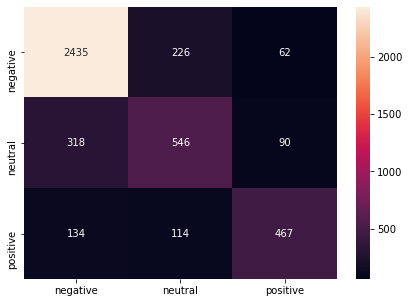

In [88]:
cm_model1= confusion_matrix(y_test, model1_result,labels=['negative','neutral', 'positive'])

print('Confusion matrix : \n', cm_model1, '\n')

df_cm_model1 = pd.DataFrame(cm_model1, index = [i for i in ['negative', 'neutral', 'positive']],
                  columns = [i for i in ['negative', 'neutral', 'positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm_model1, annot=True ,fmt='g');

#### Test using Gradient Boost Classifier

In [89]:
Classifier_CV_GBC = GradientBoostingClassifier(n_estimators = 1000, criterion='friedman_mse', max_depth=5, max_features='sqrt',
                                              ccp_alpha=0, random_state=3 )

model_CV_GBC = Classifier_CV_GBC.fit(X_train, y_train)

print(model_CV_GBC)

t2 = np.mean(cross_val_score(model_CV_GBC, airlinedata_countvector_array, labels, cv=10 ))

#print(np.mean(cross_val_score(model_CV_GBC, airlinedata_countvector_array, labels, cv=10 )))

print('\nMean cross validation score is : ', t2)

GradientBoostingClassifier(ccp_alpha=0, max_depth=5, max_features='sqrt',
                           n_estimators=1000, random_state=3)

Mean cross validation score is :  0.750068306010929


#### Predicting using the GB model

In [90]:
model_CV_GBC_result = model_CV_GBC.predict(X_test)

In [91]:
model_CV_GBC_result

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [92]:
print('Score with Train data is :', model_CV_GBC.score(X_train, y_train))

Score with Train data is : 0.9332552693208431


In [93]:
print('Score with Test data is :', model_CV_GBC.score(X_test, y_test))

Score with Test data is : 0.7782331511839709


In [94]:
print('\nThe model performance metrics are printed below: \n')

test2_classification_report = classification_report(y_test, model_CV_GBC_result , digits = 6 , output_dict = True)

#print(classification_report(y_test, model_CV_GBC_result , digits = 6))
print(classification_report(y_test, model_CV_GBC_result , digits = 6) )


The model performance metrics are printed below: 

              precision    recall  f1-score   support

    negative   0.805894  0.923981  0.860907      2723
     neutral   0.661094  0.455975  0.539702       954
    positive   0.763072  0.653147  0.703843       715

    accuracy                       0.778233      4392
   macro avg   0.743353  0.677701  0.701484      4392
weighted avg   0.767470  0.778233  0.765568      4392



In [95]:
test2_classification_report['accuracy']

0.7782331511839709

#### Printing confusion matrix , with Count Vector and GB based Model

In [96]:
print('Count of negative sentiment in test data is : ', (y_test.where(y_test == 'negative')).count() )

Count of negative sentiment in test data is :  2723


In [97]:
y_test_np = y_test.to_numpy()

In [98]:
y_test_np

array(['neutral', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [99]:
unique1, counts1 = np.unique(y_test_np, return_counts=True )

In [100]:
print('Count of sentiments in test data is : ', dict(zip(unique1, counts1)))

Count of sentiments in test data is :  {'negative': 2723, 'neutral': 954, 'positive': 715}


In [101]:
unique, counts = np.unique(model1_result, return_counts=True )

In [102]:
print('Count of sentiments in predicted data is : ', dict(zip(unique, counts)))

Count of sentiments in predicted data is :  {'negative': 2887, 'neutral': 886, 'positive': 619}


Confusion matrix : 
 [[2516  140   67]
 [ 441  435   78]
 [ 165   83  467]] 



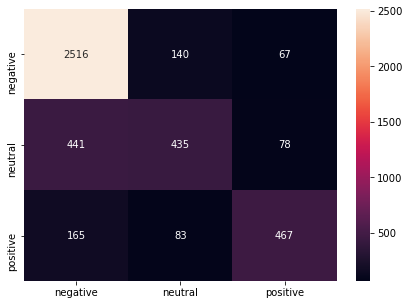

In [103]:
cm_model_CV_GBC= confusion_matrix(y_test, model_CV_GBC_result,labels=['negative','neutral', 'positive'])

print('Confusion matrix : \n', cm_model_CV_GBC, '\n')

df_cm_model_CV_GBC = pd.DataFrame(cm_model_CV_GBC, index = [i for i in ['negative', 'neutral', 'positive']],
                  columns = [i for i in ['negative', 'neutral', 'positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm_model_CV_GBC, annot=True ,fmt='g');

#### Add results to dataframe

In [104]:
row_index = row_index + 1

results_df_data = [ 2,'Count','Gradient Boosting',t2, model_CV_GBC.score(X_train, y_train), 
                   model_CV_GBC.score(X_test, y_test),test2_classification_report['accuracy'], 
                   test2_classification_report['weighted avg']['precision'],
                   test2_classification_report['weighted avg']['recall'] , 
                   test2_classification_report['weighted avg']['f1-score']]
results_df.loc[row_index] = results_df_data
results_df

,Test number,Vectorization,Model name,Mean Cross Val score,Train data score,Test data score,Accuracy,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1 score
1,1,Count,Random forest,0.745492,0.990144,0.785064,0.785064,0.779601,0.785064,0.781102
2,2,Count,Gradient Boosting,0.750068,0.933255,0.778233,0.778233,0.767470,0.778233,0.765568


### 5.b Fit and evaluate Model using TfidfVectorizer

#### Splitting the data into train and test

In [105]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(airlinedata_tfidfvector_array, labels, test_size=0.30, random_state = 3, shuffle = True)

In [106]:
X_train1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [107]:
X_train1.shape

(10248, 12975)

In [108]:
y_train1

10749     neutral
8594      neutral
4971      neutral
1183     negative
10688    negative
           ...   
9160     negative
9859     negative
11513    positive
1688     negative
5994     positive
Name: airline_sentiment, Length: 10248, dtype: object

In [109]:
y_train1.shape

(10248,)

In [110]:
y_train1.value_counts()

negative    6455
neutral     2145
positive    1648
Name: airline_sentiment, dtype: int64

In [111]:
X_test1.shape

(4392, 12975)

In [112]:
y_test1.shape

(4392,)

In [113]:
y_test1.value_counts()

negative    2723
neutral      954
positive     715
Name: airline_sentiment, dtype: int64

In [114]:
y_test1

528       neutral
14482    negative
8006     negative
14063    negative
8909     positive
           ...   
8620     negative
4370     positive
9769     negative
5764     negative
8216     positive
Name: airline_sentiment, Length: 4392, dtype: object

#### 5.b.i Using Random Forest Classifier for model building, with Tfidf based data

In [115]:
Classifier_Tfidf_vector = RandomForestClassifier(n_estimators = 100, n_jobs= -1, min_samples_split= 10, class_weight = 'balanced')

model_Tfidf_vector = Classifier_Tfidf_vector.fit(X_train1, y_train1)

print(model_Tfidf_vector)

t3 = np.mean(cross_val_score(model_Tfidf_vector, airlinedata_tfidfvector_array, labels, cv=10 ))

#print(np.mean(cross_val_score(model_Tfidf_vector, airlinedata_tfidfvector_array, labels, cv=10 )))
print('\nMean cross validation score is : \n', t3 )

RandomForestClassifier(class_weight='balanced', min_samples_split=10, n_jobs=-1)

Mean cross validation score is : 
 0.7456967213114754


#### Predicting using the model

In [116]:
model_Tfidf_vector_result = model_Tfidf_vector.predict(X_test1)

In [117]:
model_Tfidf_vector_result

array(['neutral', 'negative', 'negative', ..., 'negative', 'positive',
       'neutral'], dtype=object)

In [118]:
print('Score with Train data is :', model_Tfidf_vector.score(X_train1, y_train1))

Score with Train data is : 0.9943403590944575


In [119]:
print('Score with Test data is :', model_Tfidf_vector.score(X_test1, y_test1))

Score with Test data is : 0.7802823315118397


In [120]:
print('\nThe model performance metrics are printed below: \n')

test3_classification_report = classification_report(y_test1, model_Tfidf_vector_result , digits = 6, output_dict = True)

print(classification_report(y_test1, model_Tfidf_vector_result , digits = 6))


The model performance metrics are printed below: 

              precision    recall  f1-score   support

    negative   0.828273  0.901579  0.863373      2723
     neutral   0.613817  0.568134  0.590093       954
    positive   0.788991  0.601399  0.682540       715

    accuracy                       0.780282      4392
   macro avg   0.743693  0.690371  0.712002      4392
weighted avg   0.775295  0.780282  0.774574      4392



#### Printing confusion matrix

In [121]:
print('Count of negative sentiment in test data is : ', (y_test1.where(y_test1 == 'negative')).count() )

Count of negative sentiment in test data is :  2723


In [122]:
y_test1_np = y_test1.to_numpy()

In [123]:
y_test1_np

array(['neutral', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [124]:
unique2, counts2 = np.unique(y_test1_np, return_counts=True )

In [125]:
print('Count of sentiments in test data is : ', dict(zip(unique2, counts2)))

Count of sentiments in test data is :  {'negative': 2723, 'neutral': 954, 'positive': 715}


In [126]:
unique2, counts2 = np.unique(model_Tfidf_vector_result, return_counts=True )

In [127]:
print('Count of sentiments in predicted data is : ', dict(zip(unique2, counts2)))

Count of sentiments in predicted data is :  {'negative': 2964, 'neutral': 883, 'positive': 545}


Confusion matrix : 
 [[2435  226   62]
 [ 318  546   90]
 [ 134  114  467]] 



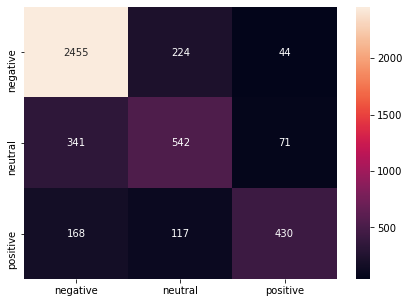

In [128]:
cm_model_Tfidf_vector= confusion_matrix(y_test1, model_Tfidf_vector_result,labels=['negative','neutral', 'positive'])

print('Confusion matrix : \n', cm_model1, '\n')

df_cm_model_Tfidf_vector = pd.DataFrame(cm_model_Tfidf_vector, index = [i for i in ['negative', 'neutral', 'positive']],
                  columns = [i for i in ['negative', 'neutral', 'positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm_model_Tfidf_vector, annot=True ,fmt='g');

In [129]:
#### add results to dataframe

In [130]:
row_index = row_index + 1

results_df_data = [ 3,'Tf-idf','Random forest',t3, model_Tfidf_vector.score(X_train1, y_train1), 
                   model_Tfidf_vector.score(X_test1, y_test1),test3_classification_report['accuracy'], 
                   test3_classification_report['weighted avg']['precision'],
                   test3_classification_report['weighted avg']['recall'] , 
                   test3_classification_report['weighted avg']['f1-score']]
results_df.loc[row_index] = results_df_data
results_df

,Test number,Vectorization,Model name,Mean Cross Val score,Train data score,Test data score,Accuracy,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1 score
1,1,Count,Random forest,0.745492,0.990144,0.785064,0.785064,0.779601,0.785064,0.781102
2,2,Count,Gradient Boosting,0.750068,0.933255,0.778233,0.778233,0.767470,0.778233,0.765568
3,3,Tf-idf,Random forest,0.745697,0.994340,0.780282,0.780282,0.775295,0.780282,0.774574


#### 5.b.ii Using Gradient Boosting Classifier for model building, with Tfidf based data

In [131]:
Classifier_GB_Tfidf_vector = GradientBoostingClassifier(n_estimators = 1000, criterion='friedman_mse', max_depth=5, max_features='sqrt',
                                              ccp_alpha=0, random_state=3)

model_Tfidf_GBC = Classifier_GB_Tfidf_vector.fit(X_train1, y_train1)

print(model_Tfidf_GBC)

t4 = np.mean(cross_val_score(model_Tfidf_GBC, airlinedata_tfidfvector_array, labels, cv=10 ))

#print(np.mean(cross_val_score(model_Tfidf_GBC, airlinedata_tfidfvector_array, labels, cv=10 )))
print('Mean cross validation score is :', t4)

GradientBoostingClassifier(ccp_alpha=0, max_depth=5, max_features='sqrt',
                           n_estimators=1000, random_state=3)
Mean cross validation score is : 0.7405737704918033


#### 5.b.ii Predicting using the GB model

In [132]:
model_Tfidf_GBC_result = model_Tfidf_GBC.predict(X_test1)

In [133]:
model_Tfidf_GBC_result

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'neutral'], dtype=object)

In [134]:
print('Score with Train data is :', model_Tfidf_GBC.score(X_train1, y_train1))

Score with Train data is : 0.982728337236534


In [135]:
print('Score with Test data is :', model_Tfidf_GBC.score(X_test1, y_test1))

Score with Test data is : 0.7827868852459017


In [136]:
print('\nThe model performance metrics are printed below: \n')

test4_classification_report = classification_report(y_test1, model_Tfidf_GBC_result , digits = 6, output_dict = True)

print(classification_report(y_test1, model_Tfidf_GBC_result , digits = 6))


The model performance metrics are printed below: 

              precision    recall  f1-score   support

    negative   0.804224  0.936834  0.865479      2723
     neutral   0.683153  0.463312  0.552155       954
    positive   0.776614  0.622378  0.690994       715

    accuracy                       0.782787      4392
   macro avg   0.754664  0.674175  0.702876      4392
weighted avg   0.773431  0.782787  0.769016      4392



#### Printing confusion matrix , with Tfidf Vector and GB based Model

In [137]:
print('Count of negative sentiment in test data is : ', (y_test1.where(y_test1 == 'negative')).count() )

Count of negative sentiment in test data is :  2723


In [138]:
y_test1_np = y_test1.to_numpy()

In [139]:
y_test1_np

array(['neutral', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [140]:
unique3, counts3 = np.unique(y_test1_np, return_counts=True )

In [141]:
print('Count of sentiments in test data is : ', dict(zip(unique3, counts3)))

Count of sentiments in test data is :  {'negative': 2723, 'neutral': 954, 'positive': 715}


In [142]:
unique4, counts4 = np.unique(model_Tfidf_GBC_result, return_counts=True )

In [143]:
print('Count of sentiments in predicted data is : ', dict(zip(unique4, counts4)))

Count of sentiments in predicted data is :  {'negative': 3172, 'neutral': 647, 'positive': 573}


Confusion matrix : 
 [[2551  122   50]
 [ 434  442   78]
 [ 187   83  445]] 



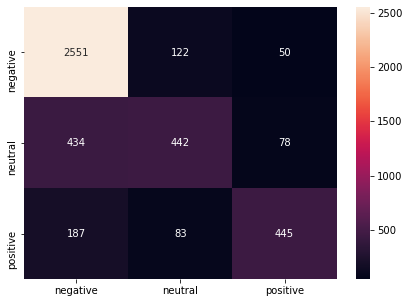

In [144]:
cm_model_Tfidf_GBC= confusion_matrix(y_test1, model_Tfidf_GBC_result,labels=['negative','neutral', 'positive'])

print('Confusion matrix : \n', cm_model_Tfidf_GBC, '\n')

df_cm_model_Tfidf_GBC = pd.DataFrame(cm_model_Tfidf_GBC, index = [i for i in ['negative', 'neutral', 'positive']],
                  columns = [i for i in ['negative', 'neutral', 'positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm_model_Tfidf_GBC, annot=True ,fmt='g');

#### Adding results to dataframe

In [145]:
row_index = row_index + 1

results_df_data = [ 4,'Tf-idf','Gradient Boosting',t4, model_Tfidf_GBC.score(X_train1, y_train1), 
                   model_Tfidf_GBC.score(X_test1, y_test1),test4_classification_report['accuracy'], 
                   test4_classification_report['weighted avg']['precision'],
                   test4_classification_report['weighted avg']['recall'] , 
                   test4_classification_report['weighted avg']['f1-score']]
results_df.loc[row_index] = results_df_data
results_df

,Test number,Vectorization,Model name,Mean Cross Val score,Train data score,Test data score,Accuracy,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1 score
1,1,Count,Random forest,0.745492,0.990144,0.785064,0.785064,0.779601,0.785064,0.781102
2,2,Count,Gradient Boosting,0.750068,0.933255,0.778233,0.778233,0.767470,0.778233,0.765568
3,3,Tf-idf,Random forest,0.745697,0.994340,0.780282,0.780282,0.775295,0.780282,0.774574
4,4,Tf-idf,Gradient Boosting,0.740574,0.982728,0.782787,0.782787,0.773431,0.782787,0.769016


In [147]:
results_df1 = results_df.sort_values(by = ['Accuracy', 'Mean Cross Val score'], ascending = False)
results_df1

,Test number,Vectorization,Model name,Mean Cross Val score,Train data score,Test data score,Accuracy,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1 score
1,1,Count,Random forest,0.745492,0.990144,0.785064,0.785064,0.779601,0.785064,0.781102
4,4,Tf-idf,Gradient Boosting,0.740574,0.982728,0.782787,0.782787,0.773431,0.782787,0.769016
3,3,Tf-idf,Random forest,0.745697,0.994340,0.780282,0.780282,0.775295,0.780282,0.774574
2,2,Count,Gradient Boosting,0.750068,0.933255,0.778233,0.778233,0.767470,0.778233,0.765568


### 6 Summarize understanding and observations 

#### Pre-processing observations:
    1> html tag removal : Did not find html tag elemnts '<' or '>' or <head> or <href> etc. Only one instance of word 
        'html' was found. Used BeautifulSoup , to make sure html tags are removed , if present. However , word html 
         was not removed. 
    2> removing http, https, html , www words : Created functions to remove these since Beautiful Soup was not able 
        to remove , as these were not in the correct html tag format.
    3> Applied contractions by using the 'contractions' package. This helps to get us the root words and standardize, 
        before applying further pre-processing like lemmatizing. It also splits words like can't to 'could not' , 
        with 'not' being a key word if we have to analyse sentiment.
    4> Accented character removal - Used unicodedata.normalize() function for this. Will help to get the appropriate 
        english language word.
    5> Removed special characters and punctuations by using REGEX and only considering a-z , A-Z and numbers 0-9. 
        This helps remove all non-alphanumeric characters. Though the tweets will still have non-english dictionary 
        words like 'naaaww' or 'Awwweesssoooomee', a vast majority of non-english words can be removed to help in 
        processing the tweets for sentiment analysis.
    6> Removed numbers using REGEX since numbers are not directly related to sentiment analysis . We are more 
        interested in words that expresee positive / neutral or negative sentiments.
    7> Converted text to lower case using python function lower(). This is to normalize the tex and remove the 
        chance of model treating same word in captial vs small case differently. In sentiment analysis , 'bad' 
        and 'BAD' should be trated equally, so converting to lwer case helps.
    8> Removed stop words to reduce dimensionality. However , included 'no' and 'not' , which are important for 
        sentiment analysis reasons.
    9> Then tokenized the remaining words and also joined back the token words back to string , in the data frame
    10> As last step in pre-processing , used 'spacy' to Lemmatize the text. this will give us the root words 
        to be analysed.
    
    

#### Vectorization observations
    1> Shape of count vectorizer and Tf-idf vectorizer output is (14640 rows , 12976 features)
    2> The to-array output from both count vectorizer and Tf-idf vectorizer show sparce matrices
    3> Count vectorizer output shows the token counts , for all 14640 rows of Tweet text, with each row indicating 
        the token and the count of words appearing in the tweets.
    4> Tf-idf vectorizer output shows the features in all rows , resultant of the Tf-idt transformation from the 
        token counts. the values are all less than 1, based on the tf-idf transformation.  
    5> In Count vectorizer , the top 15 words found and the frequencies are :
        ('flight', 4643),
         ('united', 4107),
         ('not', 3884),
         ('americanair', 2957),
         ('southwestair', 2455),
         ('usairway', 2431),
         ('jetblue', 2362),
         ('get', 2107),
         ('thank', 1534),
         ('no', 1470),
         ('hour', 1139),
         ('cancel', 1055),
         ('service', 985),
         ('delay', 955),
         ('help', 936)
    6> In Tf-idf vectorizer , the top 15 words found and the frequencies are given below. Top words are same as 
        Count vectorizer , however the values are not actual counts (since tf-idf transformation results in values 
        less than 1) , but points to the relative occurances of the words . Hence words 'flight' , 'united' etc 
        occur more in the tweets . Similar observation as in count vectorizer output.
        ('flight', 599.1023082532387),
         ('united', 570.8411151750346),
         ('not', 509.6215539407774),
         ('americanair', 474.01587974361246),
         ('jetblue', 432.1902661101106),
         ('southwestair', 426.60270782079607),
         ('usairway', 420.17800544560856),
         ('thank', 414.2983262957665),
         ('get', 351.69341915660226),
         ('no', 263.8355827794621),
         ('hour', 234.36984108367344),
         ('cancel', 211.34371997013625),
         ('help', 201.98680328764834),
         ('delay', 200.571500691713),
         ('service', 200.38793700382328),

#### Observations on performance of models
    1> Used Random Forest and Gradient Boosting classifiers for the models . When Gradient Boosting classifier was 
        run with 100 estimators the accuracy and mean cross validation scores obtained was around 0.74. After changing
        estimators = 1000 , the Accuracy of Gradient Boosting classiifer based model impoved to 0.78.
    2> The Train data score was highest , more than 0.99 , obtained  using Random Forest classifier. It was 0.98 
        and 0.93 , with Gradient Boosting Classifier. It indicates that the model was not trained good enough 
        with training data , with Gradient Boosting classifier, as compared to the Random Forest classifier based model.
    3> The best combination was use of Count vectorizer and Random Forest classifier. However , the Test data 
        accuracy score was 0.785064, meaning , the Model has the accurate prediction of positive / neutral or negative
        sentiment , in 78.50% of  Tweets. Hence the airline company can monitor the tweets and infer the sentiment, 
        with 78.50% accuracy,  by feeding new tweets to the model.
    4> Based on value_counts() for y_train and y_test, it is found that the classes for negative , neutral and positive
        sentiments are not balanced. Negative sentiment is 4 times as likely. For Random Forest classifier ,
        'class_weight=balanced' was used to improve performance. It did impove performnace with test data. 
    5> Comparing only the 'Accuracy' scores , the best combinations , from highest to lowest accuracy scores are:
    
            Vectorization	Model name	        Accuracy
           a)  Count        Random forest	    0.785064
           b)  Tf-idf	    Gradient Boosting	0.782787
           c)  Tf-idf	    Random forest	    0.780282
           d)  Count	    Gradient Boosting	0.778233

    6> All metrics for the model performances have been captured in the data frame 'results_df1'
    7> Confusion matrix has also been plotted for all the three sentiment's Actual vs Predicted values, for Negative ,
        neutral and Positive sentiments , for all the Vectorizer & Classifier combinations.
    